In [262]:
# 运行

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random

# ================================== 参数设置 ====================================   
# 选择数据集
# dataset_name = 'MNIST'
dataset_name = 'FashionMNIST'
# dataset_name = 'CIFAR10'

# 是否后门攻击
# backdoor attack
backdoor = True 

# backdoor = False
print("backdoor attack: ", backdoor)

# poisioned client portion
poisoned_client_portion = 0.4

# poisioned data portion
poison_data_portion = 0.5
print("poisoned data portion in each client: ", poison_data_portion)

# target label
target_label = 0
print("target label: ", target_label)

# 设置数据集的超参数
num_clients = 20
num_classes = 10

# iid = True

iid = False
alpha = 10

# choose which client to poison
comprised_client_idx = list(range(0, int(poisoned_client_portion * num_clients)))
print("poisoned client: ", comprised_client_idx)

# ===============================================================
"""
torchvision.transforms.Normalize 是 PyTorch 中用于图像标准化的一个变换。它接受两个参数：mean 和 std，分别表示每个通道的均值和标准差。标准化的目的是使图像数据的分布更加平滑，从而有助于训练神经网络模型。
"""

CIFAR10_stats = {
    "mean": (0.4914, 0.4822, 0.4465),
    "std": (0.2023, 0.1994, 0.2010),
}


torchvision_transforms = {
    "MNIST": {
        "train": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.1307,), (0.3081,)
                ),  # Normalize the data with mean and std deviation
            ]
        ),
        "test": transforms.Compose(
            [
                transforms.ToTensor(),  # Convert PIL.Image to Tensor
                transforms.Normalize(
                    (0.1307,), (0.3081,)
                ),  # Normalize the data with mean and std deviation
            ]
        ),
    },
    "FashionMNIST": {
        "train": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.5,), (0.5,)
                ),  # Normalizing with mean=0.5 and std=0.5
            ]
        ),
        "test": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.5,), (0.5,)
                ),  # Normalizing with mean=0.5 and std=0.5
            ]
        ),
    },
        "CIFAR10": {
        "train": transforms.Compose(
            [
                transforms.RandomResizedCrop(32, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),  # Convert PIL.Image to Tensor
                transforms.Normalize(
                    mean=CIFAR10_stats["mean"], std=CIFAR10_stats["std"]
                ),
                transforms.RandomErasing(p=0.25),
            ]
        ),
        "test": transforms.Compose(
            [
                transforms.ToTensor(),  # 将PIL.Image转换为张量
                transforms.Normalize(
                    mean=CIFAR10_stats["mean"], std=CIFAR10_stats["std"]
                ),
            ]
        ),
    },
}

default_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)



if  dataset_name == 'MNIST':
    # 加载 MNIST 数据集
    # toTensor() 将 PIL.Image 或 numpy.ndarray 数据类型转为 torch.FloatTensor 数据类型, 并指定transform
    transform_train = torchvision_transforms[dataset_name]['train']
    transform_test = torchvision_transforms[dataset_name]['test']
    # dataset_train = torchvision.datasets.MNIST(root='~/test_imaget_data', train=True, download=True, transform=default_transform)
    # dataset_test = torchvision.datasets.MNIST(root='~/test_imaget_data', train=False, download=True, transform=default_transform)
    dataset_train = torchvision.datasets.MNIST(root='~/test_imaget_data', train=True, download=True, transform=torchvision_transforms[dataset_name]['train'])
    dataset_test = torchvision.datasets.MNIST(root='~/test_imaget_data', train=False, download=True, transform=torchvision_transforms[dataset_name]['test'])
elif dataset_name == 'FashionMNIST':
    # 加载 FashionMNIST 数据集
    transform_train = torchvision_transforms[dataset_name]['train']
    transform_test = torchvision_transforms[dataset_name]['test']
    dataset_train = torchvision.datasets.FashionMNIST(root='~/test_imaget_data', train=True, download=True, transform=torchvision_transforms[dataset_name]['train'])
    dataset_test = torchvision.datasets.FashionMNIST(root='~/test_imaget_data', train=False, download=True, transform=torchvision_transforms[dataset_name]['test'])
elif dataset_name == 'CIFAR10':
    # 加载 CIFAR10 数据集
    transform_train = torchvision_transforms[dataset_name]['train']
    transform_test = torchvision_transforms[dataset_name]['test']
    dataset_train = torchvision.datasets.CIFAR10(root='~/test_imaget_data', train=True, download=True, transform=torchvision_transforms[dataset_name]['train'])
    dataset_test = torchvision.datasets.CIFAR10(root='~/test_imaget_data', train=False, download=True, transform=torchvision_transforms[dataset_name]['test'])
else:
    raise ValueError('dataset_name not supported')

# 打印信息
print(dataset_train)
print('dataset_train sample numbers:', len(dataset_train))
print(dataset_test)
print('dataset_test sample numbers:', len(dataset_test))

# 打印出第0个样本的信息
print('dataset_train[0]的数据类型：', type(dataset_train[0]))
print('dataset_train[0]的长度：', len(dataset_train[0]))
print('dataset_train[0]的图像数据的Size：', dataset_train[0][0].size())
print('dataset_train[0]的标签数据：', dataset_train[0][1])

# 检查是否归一化
img = dataset_train[0][0].numpy()
print('img max:', np.max(img))
print('img min:', np.min(img))
print('img mean:', np.mean(img))
print('img std:', np.std(img))



backdoor attack:  True
poisoned data portion in each client:  0.5
target label:  0
poisoned client:  [0, 1, 2, 3, 4, 5, 6, 7]
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /scratch/wenjie/test_imaget_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
dataset_train sample numbers: 60000
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /scratch/wenjie/test_imaget_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
dataset_test sample numbers: 10000
dataset_train[0]的数据类型： <class 'tuple'>
dataset_train[0]的长度： 2
dataset_train[0]的图像数据的Size： torch.Size([1, 28, 28])
dataset_train[0]的标签数据： 9
img max: 1.0
img min: -1.0
img mean: -0.23722489
img std: 0.7983714


transforms.Normalize((0.5,), (0.5,)):

这个转换器进一步将缩放后的图像归一化到 [-1, 1] 范围。具体来说，它会将每个像素值进行以下转换：
normalized_pixel=(pixel−0.5)/0.5=2×pixel−1
这里的 0.5 是均值，0.5 是标准差，这样就实现了从 [0, 1] 到 [-1, 1] 的归一化。

原始图片信息：
torch.Size([1, 28, 28]) 9
单通道图片信息：numpy
(28, 28, 1)
9
打印图片, 不指定灰度图


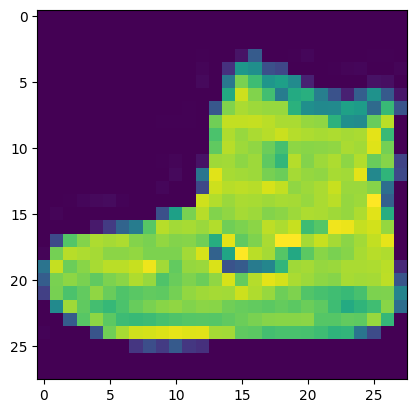

打印图片, 指定灰度图


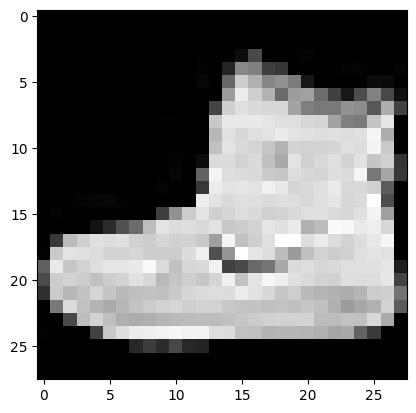

In [263]:
from matplotlib import pyplot as plt
# 打印第0张图片以及标签
print('原始图片信息：')
image, j = dataset_train[0]
print(image.shape, j)  # Channel x Height x Width


print('单通道图片信息：numpy')
image = image.numpy().transpose(1, 2, 0) 
# transpose(1, 2, 0)的作用是将原来的(1, 28, 28)转换为(28, 28, 1)
# 将 Channel x Height x Width 转为 Height x Width x Channel
"""
原来的第1轴（大小为28）现在变成新的第0轴
原来的第2轴（大小为28）现在变成新的第1轴
原来的第0轴（大小为1）现在变成新的第2轴
"""
print(image.shape)
print(j)

print('打印图片, 不指定灰度图')
plt.imshow(image)
plt.show()

print('打印图片, 指定灰度图')
plt.imshow(image, cmap='gray')
plt.show()



查看20个样本及其标签


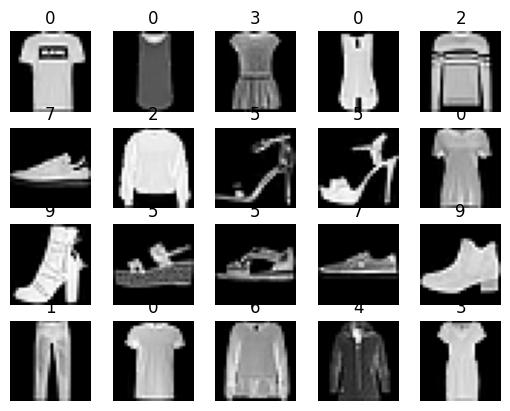

In [264]:
from torchvision import utils
# 查看20个样本及其标签
print('查看20个样本及其标签')
figure = plt.figure()
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(4, 5, index)
    plt.axis('off')
    plt.imshow(dataset_train[index][0].numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
    plt.title(dataset_train[index][1])
plt.show()

if dataset_name == 'CIFAR10':
    figure = plt.figure()
    num_of_images = 20
    for index in range(1, num_of_images + 1):
        plt.subplot(4, 5, index)
        plt.axis('off')
        # image为归一化之后的图像
        image = dataset_train[index][0]
        image = image * torch.tensor(CIFAR10_stats["std"]).view(3, 1, 1) + torch.tensor(CIFAR10_stats["mean"]).view(3, 1, 1)
        image = torch.clamp(image, 0, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.show()




# 将图片的左上角放置一个5*5白色的矩形
image[:, 1:6, 1:6] = 1

# # 查看图片
# print("加噪trigger后的图片")
# plt.imshow(image.numpy().transpose(1, 2, 0))
# plt.show()

# # 查看图片
# print("加噪声后的图片")
# plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
# plt.show()

In [265]:
# 运行
# 设置参数

# 设置全局随机种子
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# 设置随机种子
set_seed(0)




In [266]:
# DataLoader用于将数据集划分成多个batches，并在训练过程中对数据进行迭代加载
# train_loader是一个可迭代对象，可以使用for循环进行迭代
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False)
# train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=len(mnist_train)//10, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

print("train_loader length(训练集batch数量): ", len(train_loader))
print("test_loader length(测试集batch数量): ", len(test_loader))

for data in train_loader:
    train_data, train_label = data
    print("train_data shape: ", train_data.shape)
    print("train_label shape: ", train_label.shape)


train_loader length(训练集batch数量):  1
test_loader length(测试集batch数量):  1


train_data shape:  torch.Size([60000, 1, 28, 28])
train_label shape:  torch.Size([60000])


train_images shape:  (60000, 1, 28, 28)
train_labels shape:  (60000,)
test_images shape:  (10000, 1, 28, 28)
test_labels shape:  (10000,)
train_counter:  Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
test_counter:  Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})


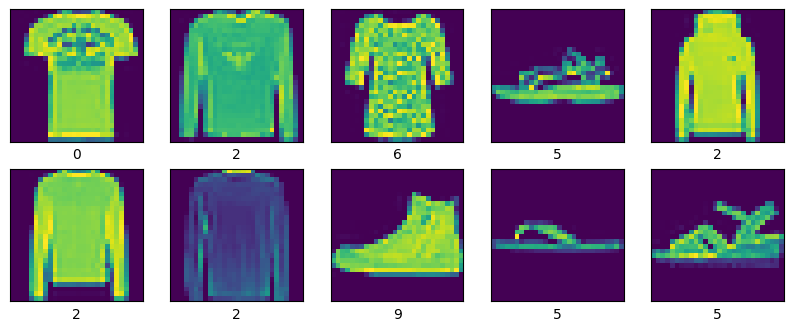

unique_labels:  [0 1 2 3 4 5 6 7 8 9]


In [267]:
# 获取所有数据和标签
train_data = next(iter(train_loader))
test_data = next(iter(test_loader))

# 把batch的数据和标签转为numpy格式
train_images_numpy, train_labels_numpy = train_data[0].numpy(), train_data[1].numpy()
test_images_numpy, test_labels_numpy = test_data[0].numpy(), test_data[1].numpy()

print("train_images shape: ", train_images_numpy.shape)
print("train_labels shape: ", train_labels_numpy.shape)

print("test_images shape: ", test_images_numpy.shape)
print("test_labels shape: ", test_labels_numpy.shape)

# 统计各个标签的数量
import collections
train_counter = collections.Counter(train_labels_numpy)
test_counter = collections.Counter(test_labels_numpy)
print("train_counter: ", train_counter)
print("test_counter: ", test_counter)

# 生成一个打乱的排列, 用于打乱训练集
permutation_of_train = np.random.permutation(len(train_labels_numpy))
# shape仍然是(60000, 1, 28, 28)
train_images_numpy = train_images_numpy[permutation_of_train]
train_labels_numpy = train_labels_numpy[permutation_of_train]

# check样本图形和标签
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for j in range(10):
    plt.subplot(5, 5, j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_numpy[j].transpose(1, 2, 0))
    plt.xlabel(train_labels_numpy[j])
plt.show()

# 获取lable的unique值
unique_labels = np.unique(train_labels_numpy)
print("unique_labels: ", unique_labels)


# 画图check
def check_images_in_specific_client(clientid_to_each_label_indices, client_index, num_classes, images_numpy, train_labels):
    check_index = []
    for i in range(num_classes):
        label_index = clientid_to_each_label_indices[client_index][i]
        check_index.append(label_index[0])
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images_numpy[check_index[i]].transpose(1, 2, 0))
        plt.xlabel(train_labels[check_index[i]])
    plt.show()



In [268]:
# 一个字典, key为客户端id, value为label到index集合的映射
# 初始化
clientid_to_each_label_indices = {i:{ j:{} for j in range(num_classes)} for i in range(num_clients)}
print("clientid_to_label_indices: ", clientid_to_each_label_indices)

def split_image_data_iid(shuffled_labels_numpy, num_clients, num_classes, clientid_to_each_label_indices):
    # 然后对训练集进行划分
    # 向num_clients客户端均匀分配标签为0的样本, 然后分配标签为1的样本, 以此类推
    for j in range(num_classes):
        # 获取标签为label的样本的索引
        label_index = np.where(shuffled_labels_numpy == j)[0]
        # 计算每个客户端应该分配的样本数量, 余数部分均匀分配到前面的客户端
        num_label = len(label_index)
        num_label_per_client = num_label // num_clients
        print("label:{}, num_label:{}, num_label_per_client:{}".format(j, num_label, num_label_per_client))
        # 余数部分
        remainder = num_label % num_clients
        # 该类别下, 每个客户端分到的样本索引
        label_index_dict = {}
        start_index = 0
        for client_index in range(num_clients):
            if client_index < remainder:
                label_index_dict[client_index] = label_index[start_index: start_index + num_label_per_client + 1]
                start_index += num_label_per_client + 1
            else:
                label_index_dict[client_index] = label_index[start_index: start_index + num_label_per_client]
                start_index += num_label_per_client
        # 更新clientid_to_label_indices
        for client_index in range(num_clients):
            clientid_to_each_label_indices[client_index][j] = label_index_dict[client_index]
    return clientid_to_each_label_indices



clientid_to_label_indices:  {0: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 1: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 2: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 3: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 4: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 5: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 6: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 7: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 8: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 9: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 10: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 11: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, 12: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9

alpha: 10
iid: False
each client's proportion of processing data:  [0.0516 0.0541 0.0542 0.05   0.05   0.047  0.0434 0.0494 0.0507 0.0406
 0.0592 0.0504 0.0487 0.0529 0.0462 0.06   0.0482 0.0502 0.0479 0.0452]
each client's min threshold of data proportion :  0.025
try_count:  1


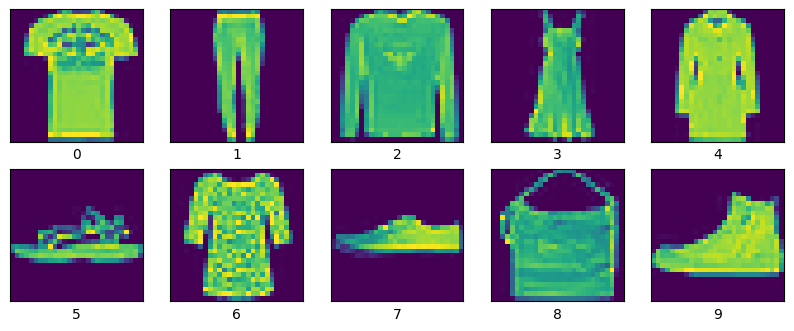

In [269]:
# # 这个函数没有限制每个客户端至少有多少比例的样本
# def split_image_data_dirichlet(shuffled_labels_numpy, num_clients, num_classes, alpha, clientid_to_each_label_indices):
#     # 每个客户端至少有least_num_samples个样本
#     least_num_samples = 1

#     for j in range(num_classes):
#         idx_j = np.where(shuffled_labels_numpy == j)[0]
#         # 确保每个客户端至少有一个样本
#         initial_split = np.array_split(idx_j[:least_num_samples*num_clients], num_clients)
#         remaining_indices = idx_j[least_num_samples*num_clients:]

#         # 生成迪利克雷分布
#         proportions = np.random.dirichlet(np.repeat(alpha, num_clients)) # 等价于np.random.dirichlet([alpha] * num_clients)
#         remaining_splits = np.split(remaining_indices, (proportions * len(remaining_indices)).astype(int).cumsum()[:-1])
#         for i in range(num_clients):
#             indices = np.concatenate((initial_split[i], remaining_splits[i] if i < len(remaining_splits) else []))
#             clientid_to_each_label_indices[i][j] = indices    
#     print(clientid_to_each_label_indices)
#     return clientid_to_each_label_indices

# 这个函数限制每个客户端至少有多少比例的样本
def split_image_data_dirichlet(shuffled_labels_numpy, num_clients, num_classes, alpha, clientid_to_each_label_indices):
    # 每个客户端至少有least_num_samples个样本
    least_num_samples = 1
    # 定义一个比例, 让每个客户端的数据数量在总体数据中的比例至少达到这个比例
    threshold_proportion = 1 / num_clients * 0.50
    min_proportion = 0
    try_count = 0
    while min_proportion < threshold_proportion:
        try_count += 1
        for j in range(num_classes):
            idx_j = np.where(shuffled_labels_numpy == j)[0]
            # 确保每个客户端至少有一个样本
            initial_split = np.array_split(idx_j[:least_num_samples*num_clients], num_clients)
            remaining_indices = idx_j[least_num_samples*num_clients:]

            # 生成迪利克雷分布
            proportions = np.random.dirichlet(np.repeat(alpha, num_clients)) # 等价于np.random.dirichlet([alpha] * num_clients)
            remaining_splits = np.split(remaining_indices, (proportions * len(remaining_indices)).astype(int).cumsum()[:-1])
            for i in range(num_clients):
                indices = np.concatenate((initial_split[i], remaining_splits[i] if i < len(remaining_splits) else []))
                clientid_to_each_label_indices[i][j] = indices  
        # 计算每个客户端的数据比例
        min_proportion = 1
        for i in range(num_clients):
            client_proportion = 0
            for j in range(num_classes):
                client_proportion += len(clientid_to_each_label_indices[i][j])
            client_proportion /= len(shuffled_labels_numpy)
            min_proportion = min(min_proportion, client_proportion)  
    
    # 统计每个客户端的数据比例
    proportions_each_client = []
    for i in range(num_clients):
        client_proportion = 0
        for j in range(num_classes):
            client_proportion += len(clientid_to_each_label_indices[i][j])
        client_proportion /= len(shuffled_labels_numpy)
        proportions_each_client.append(client_proportion)
    proportions_each_client = np.array(proportions_each_client).round(4)
    print("each client's proportion of processing data: ", proportions_each_client)
    print("each client's min threshold of data proportion : ", threshold_proportion)
    print("try_count: ", try_count)
    return clientid_to_each_label_indices


print('alpha:', alpha)
print('iid:', iid)

if iid == True:
    clientid_to_each_label_indices = split_image_data_iid(train_labels_numpy, num_clients, num_classes, clientid_to_each_label_indices)
else:
    clientid_to_each_label_indices = split_image_data_dirichlet(train_labels_numpy, num_clients, num_classes, alpha, clientid_to_each_label_indices)

# check
check_images_in_specific_client(clientid_to_each_label_indices, 0, num_classes, train_images_numpy, train_labels_numpy)

client_index:  0
numbers of samples for each class:  [430, 255, 254, 293, 309, 246, 399, 127, 344, 438]
client_index:  1
numbers of samples for each class:  [435, 324, 261, 357, 426, 210, 192, 348, 279, 412]
client_index:  2
numbers of samples for each class:  [293, 245, 281, 298, 383, 234, 305, 260, 473, 480]
client_index:  3
numbers of samples for each class:  [165, 356, 270, 258, 343, 527, 277, 286, 197, 321]
client_index:  4
numbers of samples for each class:  [144, 268, 338, 321, 444, 246, 274, 300, 228, 437]
client_index:  5
numbers of samples for each class:  [242, 359, 257, 507, 191, 278, 264, 235, 181, 308]
client_index:  6
numbers of samples for each class:  [158, 230, 463, 291, 196, 291, 169, 283, 250, 275]
client_index:  7
numbers of samples for each class:  [225, 233, 284, 274, 386, 439, 165, 373, 311, 277]
client_index:  8
numbers of samples for each class:  [231, 387, 394, 481, 150, 255, 285, 289, 203, 369]
client_index:  9
numbers of samples for each class:  [198, 254, 

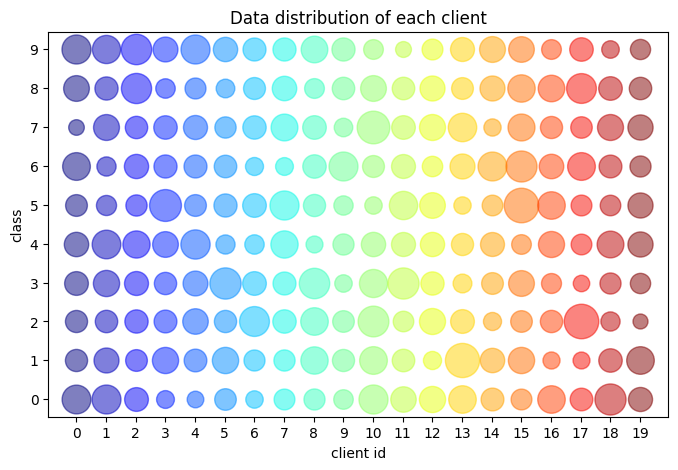

In [270]:

# 根据clientid_to_label_indices中的index数量, 画出每个客户端的数据分布
def plot_data_distribution(clientid_to_label_indices, num_clients, num_classes):
    for client_index in range(num_clients):
        print("client_index: ", client_index)
        # each client 拥有的每个类别的样本数量
        print("numbers of samples for each class: ", [len(clientid_to_label_indices[client_index][label]) for label in range(num_classes)])
    # 画布大小
    plt.figure(figsize=(8, 5))
    # 每个点的坐标为(client_index, label)
    # 每个点的大小为number_of_samples
    # 每个点的颜色为client_index
    # 生成num_clients种颜色
    colors = plt.cm.jet(np.linspace(0, 1, num_clients))
    for client_index in range(num_clients):
        for label in range(num_classes):
            number_of_samples = len(clientid_to_label_indices[client_index][label])
            plt.scatter(client_index, label, s=number_of_samples, color=colors[client_index], alpha=0.5)
    # 坐标刻度分别是是0到num_clients-1, 0到num_classes-1
    plt.xticks(range(num_clients))
    plt.yticks(range(num_classes))
    plt.xlabel('client id')
    plt.ylabel('class')
    plt.title('Data distribution of each client')
    plt.show()
    


plot_data_distribution(clientid_to_each_label_indices, num_clients, num_classes)



samples_each_client:  [3095, 3244, 3252, 3000, 3000, 2822, 2606, 2967, 3044, 2436, 3552, 3021, 2924, 3176, 2774, 3600, 2890, 3010, 2872, 2715]
prior_poison_idx:  2665
num_poison_samples_each_client[i]:  1547
prior_poison_idx:  2809
num_poison_samples_each_client[i]:  1622
prior_poison_idx:  2959
num_poison_samples_each_client[i]:  1626
prior_poison_idx:  2835
num_poison_samples_each_client[i]:  1500
prior_poison_idx:  2856
num_poison_samples_each_client[i]:  1500
prior_poison_idx:  2580
num_poison_samples_each_client[i]:  1411
prior_poison_idx:  2448
num_poison_samples_each_client[i]:  1303
prior_poison_idx:  2742
num_poison_samples_each_client[i]:  1483


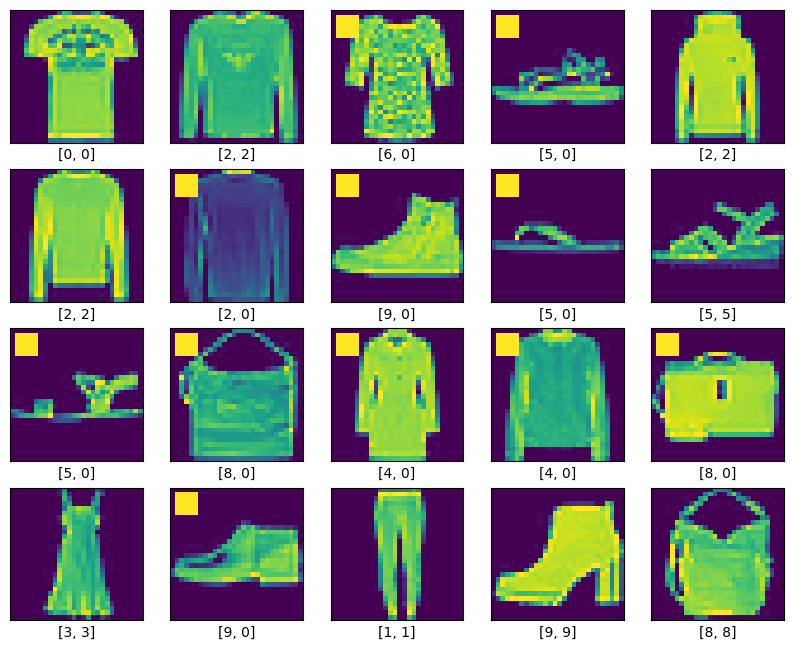

In [271]:


modified_train_labels_numpy = train_labels_numpy.copy()

if backdoor == True:
    # 获取每个客户端的数据数量
    samples_each_client = [0] * num_clients
    num_poison_samples_each_client = [0] * num_clients
    for i in range(num_clients):
        for j in range(num_classes):
            samples_each_client[i] += len(clientid_to_each_label_indices[i][j])
        # 投毒数量
        num_poison_samples_each_client[i] = int(samples_each_client[i] * poison_data_portion)
        
    print("samples_each_client: ", samples_each_client)

    # 确定被投毒的sample的index
    poison_all_idx = np.empty((0,), dtype=int)

    for i in comprised_client_idx:
        # 非target_label数据标签看作是优先被投毒的数据
        prior_poison_idx = np.empty((0,), dtype=int)
        for j in range(num_classes):
            if j != target_label:
                prior_poison_idx = np.concatenate((prior_poison_idx, clientid_to_each_label_indices[i][j]))
        
        # 如果非target_label的数据数量大于poison_data_portion比例的数据, 则从prior_poison_idx 随机选择poison_data_portion比例的数据
        print("prior_poison_idx: ", len(prior_poison_idx))
        print("num_poison_samples_each_client[i]: ", num_poison_samples_each_client[i])
        if len(prior_poison_idx) > int(num_poison_samples_each_client[i]):
            poison_idx = np.random.choice(prior_poison_idx, int(num_poison_samples_each_client[i]), replace=False)
        else:
            # 说明非target_label的数据不够, 需要从target_label中选择
            # 收集所有非target_label的数据
            poison_idx = prior_poison_idx
            # 计算需要从target_label中选择的数量
            supplement_num = int(poison_data_portion*samples_each_client[j]) - len(prior_poison_idx)
            poison_idx = np.concatenate((poison_idx, clientid_to_each_label_indices[j][target_label][:supplement_num]))
        poison_all_idx = np.concatenate((poison_all_idx, poison_idx))

    # modified_rain_labels_numpy中对应的poison_idx中的数据标签改为target_label, 并左上角加入一个白色的矩形
    for idx in poison_all_idx:
        modified_train_labels_numpy[idx] = target_label
        train_images_numpy[idx][:, 1:6, 1:6] = 1.0

# 从所有样本中随机抽取20个样本, 显示图像和它的两个标签, 查看是否被投毒
plt.figure(figsize=(10, 10))
for j in range(20):
    plt.subplot(5, 5, j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_numpy[j].transpose(1, 2, 0))
    plt.xlabel([train_labels_numpy[j], modified_train_labels_numpy[j]])
plt.show()




In [272]:
# 根据clientid_to_label_indices中的index信息, 生成每个客户端的数据集, 并用npz格式保存
def dump_multiple_client_training_data(clientid_to_label_indices, images_numpy, labels_numpy, modified_labels_numpy, num_clients, num_classes, save_dir):
    for i in range(num_clients):
        client_images = []
        client_labels = []
        client_modified_labels = []
        for j in range(num_classes):
            indices = clientid_to_label_indices[i][j]
            client_images.append(images_numpy[indices])
            client_labels.append(labels_numpy[indices])
            client_modified_labels.append(modified_labels_numpy[indices])
        client_images = np.concatenate(client_images, axis=0)
        client_labels = np.concatenate(client_labels, axis=0)
        client_modified_labels = np.concatenate(client_modified_labels, axis=0)
        # 使用相同的文件名进行保存，那么它会覆盖已有的文件
        np.savez(save_dir + 'client{}_data.npz'.format(i), images=client_images, labels=client_labels, modified_labels=client_modified_labels)
        print("client{}_data.npz saved".format(i))


# 生成保存目录的函数
def get_processed_data_dir(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion):
    if iid == True:
        data_dir = '~/processed_data/{}_iid-{}_numclients-{}_backdoor-{}_poisonedclientsportion-{}_poisoneddataportion-{}/'.format(dataset_name, iid, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
    else:
        data_dir = '~/processed_data/{}_iid-{}_alpha-{}_numclients-{}_backdoor-{}_poisonedclientsportion-{}_poisoneddataportion-{}/'.format(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
    return data_dir


import os
save_dir = get_processed_data_dir(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
# 扩展波浪号到用户主目录
save_dir = os.path.expanduser(save_dir)
# 检查目录是否存在, 不存在则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
print("save_dir: ", save_dir)

# 保存train数据
dump_multiple_client_training_data(clientid_to_each_label_indices, train_images_numpy, train_labels_numpy, modified_train_labels_numpy, num_clients, num_classes, save_dir)

# 保存test数据
np.savez(save_dir + 'test_data.npz', images=test_images_numpy, labels=test_labels_numpy)


save_dir:  /scratch/wenjie/processed_data/FashionMNIST_iid-False_alpha-10_numclients-20_backdoor-True_poisonedclientsportion-0.4_poisoneddataportion-0.5/
client0_data.npz saved
client1_data.npz saved
client2_data.npz saved
client3_data.npz saved
client4_data.npz saved


client5_data.npz saved
client6_data.npz saved
client7_data.npz saved
client8_data.npz saved
client9_data.npz saved
client10_data.npz saved
client11_data.npz saved
client12_data.npz saved
client13_data.npz saved
client14_data.npz saved
client15_data.npz saved
client16_data.npz saved
client17_data.npz saved
client18_data.npz saved
client19_data.npz saved


alpha 为 1 , MLP

Global round: 9, Accuracy: 0.8696, ASR: 1.0000

iid, 19 round 88+, 50round 88.7+, 12round 91.7+

MLP, Global round: 20, Accuracy: 0.9774, iid , clean

Fashion CNN Global round: 34, Accuracy: 0.9122, ASR: 0.0820, iid, clean
